In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal

1. The data in data(bangladesh) are 1934 women from the 1989 Bangladesh Fer-
tility Survey. For each woman, we know which district she lived in, her number
of living.children, her age.centered, whether she lived in an urban center,
and finally whether or not she used contraception (use.contraception).
In this first problem, I only want you to investigate the proportion of women using
contraception in each district. Use partial pooling (varying effects). Then compare
the varying effect estimates to the raw empirical proportion in each district. Explain
the differences between the estimates and the data.
Note that district number 54 is absent in the data. This causes some problems in
indexing the parameters. The simplest fix is just to tell ulam manually how long the
vector should be, like this: vector[61]:a ~ normal(abar,sigma). Pay special
attention to district number 54’s estimate.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/petrushev/statistical-rethinking/master/data/bangladesh.csv', sep=";")
df['d'] = pd.factorize(df['district'])[0]
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,d
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<AxesSubplot:title={'center':'empirical pct of women using contraception by district'}, xlabel='d'>

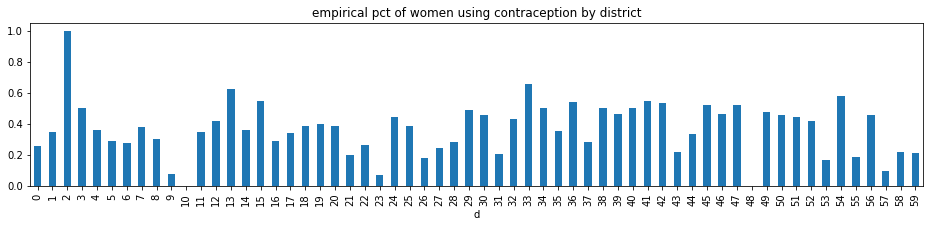

In [3]:
# the proportion of women using contraception in each district
empirical_pct = df.groupby('d')['use.contraception'].sum()/df.groupby('d').woman.nunique()
empirical_pct.plot(kind='bar', figsize=(16,3), title='empirical pct of women using contraception by district')

In [4]:
def model11(d, conc=None):
    # priors
    a =  numpyro.sample('a', dist.Normal(0, 1.5), sample_shape=df.d.unique().shape)
    # likelihood
    logits = a[d]
    numpyro.sample('conc_hat', dist.Bernoulli(logits=logits), obs=conc)

kernel = NUTS(model11)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(0), df.d.values, df['use.contraception'].values)

samples_11 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1559.57it/s, 7 steps of size 4.93e-01. acc. prob=0.86]


In [5]:
def model12(d, conc=None):
    # priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample('a', dist.Normal(a_bar,sigma), sample_shape=df.d.unique().shape)
    # likelihood
    logits = a[d]
    numpyro.sample('conc_hat', dist.Bernoulli(logits=logits), obs=conc)

kernel = NUTS(model12)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(0), df.d.values, df['use.contraception'].values)

samples_12 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1179.64it/s, 15 steps of size 3.76e-01. acc. prob=0.90]


In [6]:
model_11 = pd.DataFrame(expit(samples_11.posterior['a'].mean(axis=0).mean(axis=0).values))
model_12 = pd.DataFrame(expit(samples_12.posterior['a'].mean(axis=0).mean(axis=0).values))
aux = pd.concat([model_11.assign(model='model_11'),
                 model_12.assign(model='model_12')]).rename(columns={0:'prob'}).reset_index()

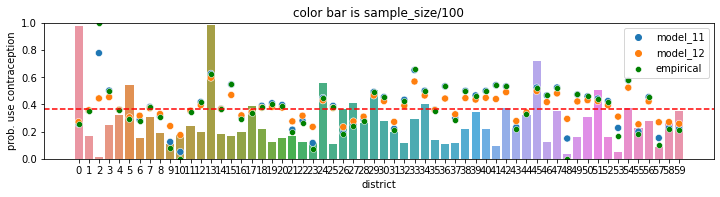

In [7]:
import seaborn as sns
g = sns.barplot(data=(df.groupby('d').woman.nunique()/120).reset_index(), x='d', y = 'woman')
sns.scatterplot(data=aux, x='index', y='prob', hue='model', s=50)
sns.scatterplot(data=empirical_pct, color ='green', label = 'empirical')
g.set(ylim=(0,1), xlabel='district', ylabel='prob. use contraception')
g.figure.set_size_inches(12,2.5)
g.axhline(expit(samples_12.posterior['a_bar'].mean().values), ls='--', c='r')
plt.title('color bar is sample_size/100')
plt.show()

Comparing empirical to the two model results. The model results are often less extreme, expecially for model_12 which models the variance in addition to the mean, and where the sample size is very small such as distcit 2 and 48. This is because the model assumes shared underlying factors for the different districts and thus has a more moderate or evened-out estimates. 

2. First, draw a DAG that includes all five variables: (1) Uses contraception C (2)
Age A (3) Children K (4) Urban U (5) District D. You don’t have to be an expert on
fertility. But do think about which variables can influence which other variables.
Second, design an estimation strategy to identify both the total and direct causal
effects of living in an urban center on contraceptive use. Those are your estimands.
Consider causal relationships among the variables. Then use your DAG to justify
an adjustment set that will yield the estimate of the causal effect of urban living on
contraceptive use.
Do not run a statistical model (yet). I just want you to try to design an analy-
sis. There is no firm right answer. Just apply the backdoor criterion and rules of
d-separation (the elemental confounds) correctly to the DAG you design.

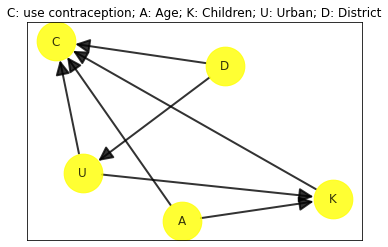

In [8]:
# draw DAG
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("A", "C"), ("U", "C"), ("D", "C"), 
                      ("K", "C"), ("U", "K"), ("D", "U"),
                      ("A","K")
                     ])
nx.draw_networkx(graph, arrows=True, alpha=0.8, node_color = 'yellow',
                width=2, node_size=1500, arrowsize = 30)
plt.title ("C: use contraception; A: Age; K: Children; U: Urban; D: District")
plt.show()

Causal U to C
- Total: close D as backdoor; U to C direct, U to K to C; A isn't necessary 
- Direct: U to C, stratify by D, K and A 

3. Now build one or more statistical models to estimate the total and the direct
causal effects of urban living on contraceptive use. Again include district as a simple
varying effect (as in problem 1) so that each district has its own average contraceptive
use. You may also want to stratify the effect of urban living by district. If you do,
think carefully about how to do this statistically

In [9]:
# total effect
def model31(u, d, conc=None):
    # priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample('a', dist.Normal(a_bar,sigma), sample_shape=df.d.unique().shape)
    b =  numpyro.sample('b', dist.Normal(0,0.5))
    # likelihood
    logits = a[d] + b*u
    numpyro.sample('conc_hat', dist.Bernoulli(logits=logits), obs=conc)

kernel = NUTS(model31)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(0), df.urban.values, df.d.values, df['use.contraception'].values)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1139.42it/s, 15 steps of size 3.91e-01. acc. prob=0.89]


In [10]:
posterior_31 = mcmc.get_samples()
posterior_31.pop('a')
print_summary(posterior_31, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     a_bar     -0.69      0.08     -0.69     -0.82     -0.56   1563.10      1.00
         b      0.61      0.11      0.61      0.44      0.80   2014.14      1.00
     sigma      0.46      0.08      0.45      0.33      0.57    602.44      1.01



Urban living has a substantial impact (avg. 80% across different districts) on the use of contraception

In [58]:
 # total effect stratified by district 
def model311(u, d, conc=None):
    # priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0,1.5),  sample_shape=(2,))
    sigma = numpyro.sample('sigma', dist.Exponential(1),  sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    # adaptive priors
    cov = jnp.outer(sigma, sigma)*rho
    i, j = d.nunique(), u.nunique()
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(a_bar, cov), sample_shape=(i,j))
    # likelihood
    theta =  ab_did[:,:,0][d.values,u.values] + ab_did[:,:,1][d.values,u.values]*u.values
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=conc)

kernel = NUTS(model311)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(0), df.urban, df.d, df['use.contraception'].values)

sample: 100%|██████████| 1000/1000 [00:06<00:00, 161.11it/s, 63 steps of size 6.64e-02. acc. prob=0.96]


In [59]:
posterior_311 = mcmc.get_samples()
posterior_311.pop('ab_did')
posterior_311.pop('rho')
print_summary(posterior_311, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_bar[0]     -0.71      0.10     -0.70     -0.86     -0.54    253.22      1.00
  a_bar[1]      0.71      0.16      0.71      0.46      0.96    102.01      1.00
  sigma[0]      0.58      0.09      0.58      0.45      0.74    173.91      1.01
  sigma[1]      0.36      0.23      0.30      0.08      0.67     12.78      1.01



The average total effect of Urban livingn on Contraception is till strong after stratifying by districts, as a_bar[1] is high. But there are some variability among districts as sigma[1] has a high std at 0.23.  

In [50]:
 # direct effect 
 # code from chapter 12.34 is relevant here 

from numpyro.distributions.transforms import OrderedTransform
Kprior=jnp.repeat(2, 3)

def model32(A, K, U, D, conc=None):
    # priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample('a', dist.Normal(a_bar,sigma), sample_shape=df.d.unique().shape)
    bU =  numpyro.sample('bU', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    bK = numpyro.sample('bK', dist.Normal(0,0.5))
    delta = numpyro.sample("delta", dist.Dirichlet(Kprior))
    delta_j = jnp.pad(delta, (1, 0))
    kappa = numpyro.sample(
        "kappa",
        dist.TransformedDistribution(
            dist.Normal(0, 2).expand([2]), OrderedTransform()
        ),
    )
    delta_E = jnp.sum(jnp.where(jnp.arange(1,5) <= K[..., None], delta_j, 0), -1)
    # likelihood
    logits = a[D] + bU*U + bA*A + bK*delta_E
    numpyro.sample('conc_hat', dist.OrderedLogistic(logits, kappa), obs=conc)

kernel = NUTS(model32)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(0), 
        df['age.centered'].values, df['living.children'].values,
        df.urban.values, df.d.values, df['use.contraception'].values)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 323.99it/s, 31 steps of size 9.36e-02. acc. prob=0.88]


In [31]:
posterior_32 = mcmc.get_samples()
posterior_32.pop('a')
print_summary(posterior_32, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     a_bar     -0.13      0.66     -0.12     -1.22      0.81     12.30      1.00
        bA     -0.03      0.01     -0.03     -0.04     -0.02    697.98      1.00
        bK      1.28      0.15      1.28      1.05      1.54    427.35      1.00
        bU      0.68      0.11      0.67      0.50      0.86    679.37      1.00
  delta[0]      0.74      0.09      0.74      0.59      0.86    712.67      1.01
  delta[1]      0.17      0.08      0.16      0.04      0.29    727.80      1.00
  delta[2]      0.09      0.05      0.08      0.01      0.17    909.86      1.02
  kappa[0]      1.45      0.67      1.44      0.31      2.43     12.66      1.00
  kappa[1]     11.54      2.15     11.38      7.91     14.88    147.02      1.01
     sigma      0.48      0.09      0.48      0.33      0.61    250.97      1.00



bU is very similar to the total effect which is around 80%. Thus the effect through K is almost none. 
Delta is the incremental effect of each additional child after the first. The 2nd child has the biggest impact.

In [ ]:
 # direct effect stratified by district
 ## how to implement this in numpyro??? 

 